<a href="https://colab.research.google.com/github/bohuslavska/ai-house-fake-news-detection-homework/blob/master/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import calendar

import pandas as pd
import numpy as np 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import torch
import torch.nn as nn
import re
import string
from langdetect import detect as detect_lang

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV


from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import seaborn as sns
from tqdm import tqdm

from copy import deepcopy
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import ru_core_news_lg
nlp = ru_core_news_lg.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# In this homework I will continue to explore dataset propaganda-detection-our-data. As far as Short EDA is a part of Homework3 I will skip it in a current notebook and move forward instantly to the text processing and modification of the datasets.

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_test.csv')

combined = [df_train, df_val, df_test]

In [4]:
def detect_lang_with_excep(input):
    try:
        return detect_lang(input)
    except:
        return "none"
        
for d in combined:
  d["lang"] = d["text"].apply(detect_lang_with_excep)
  print(d["lang"].value_counts())

ru    867
bg      7
uk      2
mk      2
da      1
so      1
Name: lang, dtype: int64
ru    123
ro      1
en      1
bg      1
et      1
Name: lang, dtype: int64
ru      242
uk        4
none      1
bg        1
Name: lang, dtype: int64


In [5]:
#Function for the text preprocessing.

nlp = spacy.load('ru_core_news_lg')

def remove_emojis(data):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def text_preprocessing(text):
    text = remove_emojis(text)
    russian_stop_words = stopwords.words('russian')
    lower_text = [i.lower() for i in text]
    custom_punct = string.punctuation +"«" + "»‎"
    no_latin = [i for i in lower_text if i not in list(string.ascii_letters)]
    no_punct = [i for i in no_latin if i not in list(custom_punct)]
    no_punct = ''.join(no_punct)
    no_sw = [i for i in no_punct.split() if i not in russian_stop_words]
    no_sw = ' '.join(no_sw)
    document = nlp(no_sw)
    result = " ".join([token.lemma_ for token in document])
    return result

In [6]:
for d in combined:
  d['preprocessed_text'] = d['text'].apply(lambda x: text_preprocessing(x))

df_train

,id,text,label,lang,preprocessed_text
0,00000_03514,Чернигов прилет во многоэтажку. Говорят русска...,True,ru,чернигов прилёт многоэтажка говорить русский р...
1,00002_06059,Председатель Следственного комитета РФ Алексан...,True,ru,председатель следственный комитет рф александр...
2,00003_08645,Все сейчас массово хотят уехать со Львова.,True,ru,массово хотеть уехать львов
3,00004_00901,«К военным подошли бабушки и попросили убрать ...,True,ru,военный подойти бабушка попросить убрать аллея...
4,00006_06251,"С уважение отношусь к Лобаеву, но Владислав, е...",True,ru,уважение относиться лобаеву владислав вопрос п...
...,...,...,...,...,...
875,08891_03363,"?? ?? ? Появились цели захватить Москву, Чечню...",True,ru,появиться цель захватить москва чечня крым обр...
876,08892_01638,"В украинских пабликах пишут, что российский сп...",True,ru,украинских пабликах писать российский спецназ ...
877,08893_03217,"Сообщается, что в дом попала ракета ПВО ВС Укр...",True,ru,сообщаться дом попасть ракета пво вс украина
878,08896_08921,"В Росавиации сообщили , что с сегодняшнего дня...",True,ru,росавиации сообщить сегодняшний день россия ог...


In [7]:
for d in combined:
  print(d.shape)
  d.drop_duplicates(inplace=True)
  d.drop(d[d.lang != 'ru'].index, inplace=True)
  d.drop(columns = ['id', 'text', 'lang'], inplace = True)
  d['label'] = d['label'] * 1
  d.reset_index(drop = True, inplace = True)
  print(d.shape)

(880, 5)
(867, 2)
(127, 5)
(123, 2)
(248, 5)
(242, 2)


# Hyperparameter tuning for different combinations of models and vectorizers

###CountVectorizer + LogisticRegression

In [8]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
all_folds = [i for i in skf.split(df_train['preprocessed_text'], df_train['label'])]

In [9]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []

model_dict = {}
test_scores = []

for fold_id, (train_index, test_index) in enumerate(all_folds):
        X_train_fold, X_test_fold = df_train['preprocessed_text'][train_index], df_train['preprocessed_text'][test_index]
        y_train_fold, y_test_fold = df_train['label'][train_index], df_train['label'][test_index]

        model = Pipeline([("vectorizer", CountVectorizer()),
        ("log_reg", LogisticRegression())])

        params = {
        'vectorizer__max_df': (0.5, 0.75, 1.0),
        'vectorizer__max_features': [None, 5000, 10000, 50000],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
        'log_reg__penalty': ['l2'],
        'log_reg__solver' : ('newton-cg', 'lbfgs', 'liblinear'),
        'log_reg__C' : [100, 10, 1.0, 0.1, 0.01]}

        GridSearch_LR = GridSearchCV(model, params, scoring='roc_auc', n_jobs = -1, cv = 3)
        
        GridSearch_LR.fit(X_train_fold, y_train_fold)

        print(f'For {fold_id} fold the best model is {GridSearch_LR.best_estimator_}')

        all_models.append(GridSearch_LR)
        
        fold_train_preds = GridSearch_LR.predict_proba(X_train_fold)[:,1]
        fold_test_preds = GridSearch_LR.predict_proba(X_test_fold)[:,1]

        fold_train_targets = y_train_fold.values
        fold_test_targets = y_test_fold.values

        all_train_preds.append(fold_train_preds)
        all_test_preds.append(fold_test_preds)

        all_train_targets.append(fold_train_targets)
        all_test_targets.append(fold_test_targets)

        test_roc_auc = roc_auc_score(fold_test_targets, fold_test_preds)
        
        test_scores.append(test_roc_auc)  

        for_dict = {test_roc_auc: GridSearch_LR.best_estimator_}
        model_dict.update(for_dict)

        print(f'{fold_id}')
        print('Train Roc Auc Score:', roc_auc_score(fold_train_targets, fold_train_preds))
        print('Test Roc Auc Score:', test_roc_auc)

For 0 fold the best model is Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5, ngram_range=(1, 3))),
                ('log_reg', LogisticRegression(C=0.01, solver='liblinear'))])
0
Train Roc Auc Score: 0.9882042003689513
Test Roc Auc Score: 0.7147494707127734
For 1 fold the best model is Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5, ngram_range=(1, 3))),
                ('log_reg', LogisticRegression(C=0.01, solver='newton-cg'))])
1
Train Roc Auc Score: 0.9907976550008882
Test Roc Auc Score: 0.7105780022446689
For 2 fold the best model is Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5, ngram_range=(1, 3))),
                ('log_reg', LogisticRegression(C=0.01, solver='newton-cg'))])
2
Train Roc Auc Score: 0.9858600338014211
Test Roc Auc Score: 0.7578347578347577
For 3 fold the best model is Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5, ngram_range=(1, 3))),
                ('log_reg', LogisticRegression(C=0.01))])
3
Train Roc Auc Score: 0.

In [10]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train:", roc_auc_score(all_train_targets, all_train_preds));
print("OOF Test:", roc_auc_score(all_test_targets, all_test_preds));

OOF Train: 0.9844180567683114
OOF Test: 0.7176099701756575


In [11]:
#Choosing the best model

key = max(test_scores)
best_lr_cv = model_dict[key]
print('The best model is', best_lr_cv)

The best model is Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5, ngram_range=(1, 3))),
                ('log_reg', LogisticRegression(C=0.01, solver='newton-cg'))])


### Tfidfvectorizer + LogisticRegression



In [13]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []

model_dict = {}
test_scores = []

for fold_id, (train_index, test_index) in enumerate(all_folds):
        X_train_fold, X_test_fold = df_train['preprocessed_text'][train_index], df_train['preprocessed_text'][test_index]
        y_train_fold, y_test_fold = df_train['label'][train_index], df_train['label'][test_index]

        model = Pipeline([("vectorizer", TfidfVectorizer()),
        ("log_reg", LogisticRegression())])

        params = {
            'vectorizer__max_df': (0.5, 0.75, 1.0),
            'vectorizer__max_features': [None, 5000, 10000, 50000],
            'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
            'vectorizer__use_idf': (True, False),
            'vectorizer__norm': ('l1', 'l2', None),
            'log_reg__penalty': ['l2'],
            'log_reg__solver' : ('newton-cg', 'lbfgs', 'liblinear'),
            'log_reg__C' : [100, 10, 1.0, 0.1, 0.01]}

        GridSearch_LR = GridSearchCV(model, params, scoring='roc_auc', n_jobs = -1, cv = 3)
        
        GridSearch_LR.fit(X_train_fold, y_train_fold)

        print(f'For {fold_id} fold the best model is {GridSearch_LR.best_estimator_}')

        fold_train_preds = GridSearch_LR.predict_proba(X_train_fold)[:,1]
        fold_test_preds = GridSearch_LR.predict_proba(X_test_fold)[:,1]

        fold_train_targets = y_train_fold.values
        fold_test_targets = y_test_fold.values

        all_train_preds.append(fold_train_preds)
        all_test_preds.append(fold_test_preds)
        all_train_targets.append(fold_train_targets)
        all_test_targets.append(fold_test_targets)

        test_scores.append(test_roc_auc)        
        for_dict = {test_roc_auc: GridSearch_LR.best_estimator_}
        model_dict.update(for_dict)

        print(f'{fold_id}')
        print('Train Roc Auc Score:', roc_auc_score(fold_train_targets, fold_train_preds))
        print('Test Roc Auc Score:', roc_auc_score(fold_test_targets, fold_test_preds))

For 0 fold the best model is Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 3), norm=None,
                                 use_idf=False)),
                ('log_reg', LogisticRegression(C=0.01, solver='liblinear'))])
0
Train Roc Auc Score: 0.9882042003689513
Test Roc Auc Score: 0.7147494707127734
For 1 fold the best model is Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 3), norm=None,
                                 use_idf=False)),
                ('log_reg', LogisticRegression(C=0.01, solver='newton-cg'))])
1
Train Roc Auc Score: 0.9907976550008882
Test Roc Auc Score: 0.7105780022446689
For 2 fold the best model is Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 3), norm=None)),
                ('log_reg', LogisticRegression(C=0.01, solver='liblinear'))])
2
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.7417378917378917
For 3 fold the best model is

In [14]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train:", roc_auc_score(all_train_targets, all_train_preds));
print("OOF Test:", roc_auc_score(all_test_targets, all_test_preds));

OOF Train: 0.9900508743181792
OOF Test: 0.7152739190093329


In [15]:
#Choosing the best model

key = max(test_scores)
best_lr_tf = model_dict[key]
print("The best model is", best_lr_tf)

The best model is Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, ngram_range=(1, 3), norm=None,
                                 use_idf=False)),
                ('log_reg', LogisticRegression(C=0.01, solver='newton-cg'))])


### Sentence Embeddings + Logistic Regression

In [61]:
train = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_train.csv')
val = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_val.csv')
test = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_test.csv')

combined = [train, val, test]

In [62]:
# Here we create a function for light text preprocessing so that transformer can benefit from more text information.


def light_preprocessing(text):
    text = remove_emojis(text)
    lower_text = [i.lower() for i in text]
    custom_punct = string.punctuation +"«" + "»‎"
    no_latin = [i for i in lower_text if i not in list(string.ascii_letters)]
    no_punct = [i for i in no_latin if i not in list(custom_punct)]
    no_punct = ''.join(no_punct)
    return no_punct

for d in combined:
  d['preprocessed_light'] = d['text'].apply(lambda x: light_preprocessing(x))

train

,id,text,label,preprocessed_light
0,00000_03514,Чернигов прилет во многоэтажку. Говорят русска...,True,чернигов прилет во многоэтажку говорят русская...
1,00002_06059,Председатель Следственного комитета РФ Алексан...,True,председатель следственного комитета рф алексан...
2,00003_08645,Все сейчас массово хотят уехать со Львова.,True,все сейчас массово хотят уехать со львова
3,00004_00901,«К военным подошли бабушки и попросили убрать ...,True,к военным подошли бабушки и попросили убрать а...
4,00006_06251,"С уважение отношусь к Лобаеву, но Владислав, е...",True,с уважение отношусь к лобаеву но владислав есл...
...,...,...,...,...
875,08891_03363,"?? ?? ? Появились цели захватить Москву, Чечню...",True,появились цели захватить москву чечню и кры...
876,08892_01638,"В украинских пабликах пишут, что российский сп...",True,в украинских пабликах пишут что российский спе...
877,08893_03217,"Сообщается, что в дом попала ракета ПВО ВС Укр...",True,сообщается что в дом попала ракета пво вс украины
878,08896_08921,"В Росавиации сообщили , что с сегодняшнего дня...",True,в росавиации сообщили что с сегодняшнего дня ...


In [63]:
for d in combined:
  print(d.shape)
  d.drop_duplicates(inplace=True)
  d.drop(columns = ['id', 'text'], inplace = True)
  d['label'] = d['label'] * 1
  d.reset_index(drop = True, inplace = True)
  print(d.shape)

(880, 4)
(880, 2)
(127, 4)
(127, 2)
(248, 4)
(248, 2)


In [64]:
#I have chosen distiluse-base-multilingual-cased-v1 model because it supports russian.

sent_tr = SentenceTransformer('distiluse-base-multilingual-cased-v1', device="cpu")

In [65]:
train_embs = sent_tr.encode(train["preprocessed_light"].to_list())
val_embs = sent_tr.encode(val["preprocessed_light"].to_list())
test_embs = sent_tr.encode(test["preprocessed_light"].to_list())

In [66]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []

model_dict = {}
test_scores = []

params = {'log_reg__solver' : ('newton-cg', 'lbfgs', 'liblinear'),
            'log_reg__C' : [100, 10, 1.0, 0.1, 0.01]}

for fold_id, (train_index, test_index) in enumerate(all_folds):

        X_train_fold, X_test_fold = train_embs[train_index], train_embs[test_index]
        y_train_fold, y_test_fold = train['label'][train_index], train['label'][test_index]

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("log_reg", LogisticRegression(max_iter = 10000))])
        
        params = {
        'log_reg__solver' : ('newton-cg', 'lbfgs', 'liblinear'),
        'log_reg__C' : [100, 10, 1.0, 0.1, 0.01]}

        GridSearch_LR = GridSearchCV(model, params, scoring='roc_auc', n_jobs = -1, cv = 3)
        
        GridSearch_LR.fit(X_train_fold, y_train_fold)

        print(f'For {fold_id} fold the best model is {GridSearch_LR.best_estimator_}')

        all_models.append(GridSearch_LR)
        
        fold_train_preds = GridSearch_LR.predict_proba(X_train_fold)[:,1]
        fold_test_preds = GridSearch_LR.predict_proba(X_test_fold)[:,1]

        fold_train_targets = y_train_fold.values
        fold_test_targets = y_test_fold.values

        all_train_preds.append(fold_train_preds)
        all_test_preds.append(fold_test_preds)
        all_train_targets.append(fold_train_targets)
        all_test_targets.append(fold_test_targets)

        test_scores.append(test_roc_auc)        
        for_dict = {test_roc_auc: GridSearch_LR.best_estimator_}
        model_dict.update(for_dict)

        print(f'{fold_id}')
        print('Train Roc Auc Score:', roc_auc_score(fold_train_targets, fold_train_preds))
        print('Test Roc Auc Score:', roc_auc_score(fold_test_targets, fold_test_preds))

For 0 fold the best model is Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=0.01, max_iter=10000))])
0
Train Roc Auc Score: 0.937067822088602
Test Roc Auc Score: 0.7475500345065563


/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


For 1 fold the best model is Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.01, max_iter=10000,
                                    solver='newton-cg'))])
1
Train Roc Auc Score: 0.9376972715157467
Test Roc Auc Score: 0.6995566995566995
For 2 fold the best model is Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=0.01, max_iter=10000))])
2
Train Roc Auc Score: 0.9309325734651928
Test Roc Auc Score: 0.7454013377926421


/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


For 3 fold the best model is Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.01, max_iter=10000,
                                    solver='newton-cg'))])
3
Train Roc Auc Score: 0.9331042988019733
Test Roc Auc Score: 0.7107843137254901
For 4 fold the best model is Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=0.01, max_iter=10000))])
4
Train Roc Auc Score: 0.9355346599606386
Test Roc Auc Score: 0.7161616161616162


In [67]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)


print("OOF Train:", roc_auc_score(all_train_targets, all_train_preds));
print("OOF Test:", roc_auc_score(all_test_targets, all_test_preds));

OOF Train: 0.9349263877941674
OOF Test: 0.7238430356941786


In [68]:
#Choosing the best model

key = max(test_scores)
best_emb = model_dict[key]
print("The best model is", best_emb)

The best model is Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=0.01, max_iter=10000))])


#How The Best Models Perform On Validation And Test Datasets


In [122]:
#Here we use classification_report function from workshop "Instrumnets for detecting fake news"

def classification_report (train_probs, train_real, train_texts, test_probs, test_real, test_texts, val_probs,val_real,val_texts,tresh=0.5):
  
    train_texts = np.array(train_texts)
    test_texts = np.array(test_texts)
    val_texts = np.array(val_texts)

    for real, prob, name, text in zip(
        [train_real, test_real, val_real],
        [train_probs, test_probs, val_probs],
        ["train", "test", "val"],
        [train_texts, test_texts, val_texts]
    ):
        print(
            f"{name} Roc Auc: {roc_auc_score(real, prob)}"
        )
        print(
            f"{name} Accuracy : {accuracy_score(real, prob > tresh)}"
        )
        plt.figure(figsize=(10,5))
        plt.title(f"{name} Real vs Pred distribution")
        plt.hist(real, bins=30, label="Real")
        plt.hist(prob, bins=30, label="Pred")
        plt.legend()
        plt.show();

        plt.figure(figsize=(10,10))
        cm = confusion_matrix(
            real, 
            prob > tresh, 
        )
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, 
        )
        disp.plot()
        plt.show();

###CountVectorizer + LogisticRegression



train Roc Auc: 0.9839708333805837
train Accuracy : 0.6793540945790081


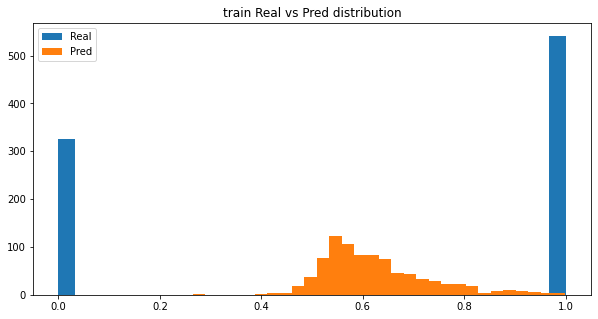

<Figure size 720x720 with 0 Axes>

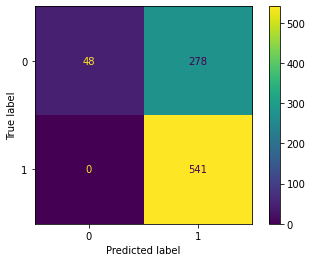

test Roc Auc: 0.7789711505039971
test Accuracy : 0.5661157024793388


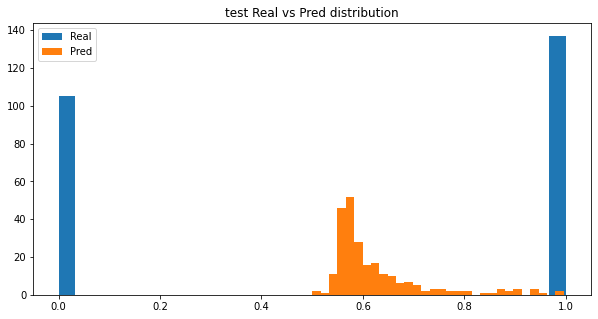

<Figure size 720x720 with 0 Axes>

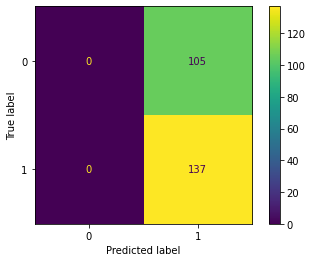

val Roc Auc: 0.7190852625635233
val Accuracy : 0.6260162601626016


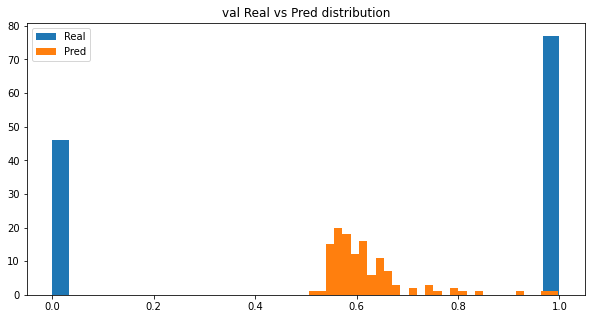

<Figure size 720x720 with 0 Axes>

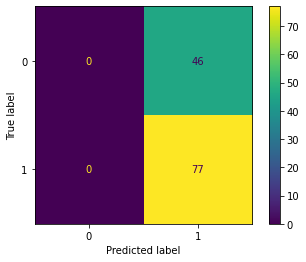

In [123]:
log_reg = best_lr_cv.fit(df_train['preprocessed_text'], df_train['label'])

log_reg_train_probs = log_reg.predict_proba(df_train['preprocessed_text']) #have
log_reg_test_probs = log_reg.predict_proba(df_test['preprocessed_text']) #have
log_reg_val_probs = log_reg.predict_proba(df_val['preprocessed_text']) #have

classification_report(
    train_probs = log_reg_train_probs[:,1],
    train_real = df_train["label"].astype(int).values,
    train_texts = df_train["preprocessed_text"].to_list(),

    test_probs=log_reg_test_probs[:,1],
    test_real=df_test["label"].astype(int).values,
    test_texts=df_test["preprocessed_text"].to_list(),

    val_probs=log_reg_val_probs[:,1],
    val_real=df_val["label"].astype(int).values,
    val_texts=df_val["preprocessed_text"].to_list(),
)

### Tfidfvectorizer + LogisticRegression


train Roc Auc: 0.9839708333805837
train Accuracy : 0.6793540945790081


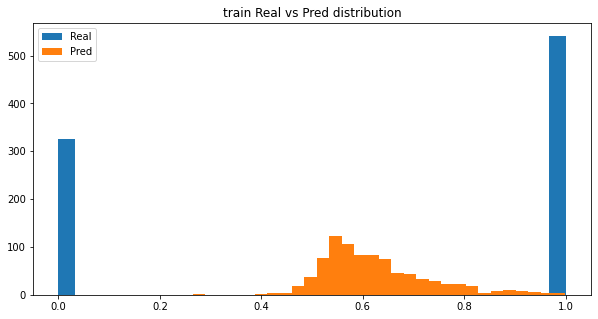

<Figure size 720x720 with 0 Axes>

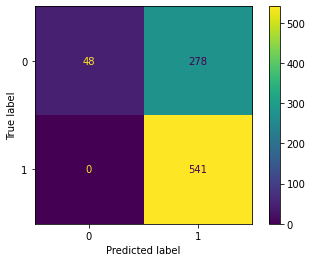

test Roc Auc: 0.7789711505039971
test Accuracy : 0.5661157024793388


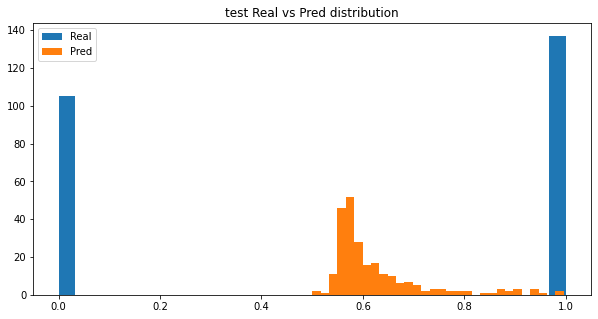

<Figure size 720x720 with 0 Axes>

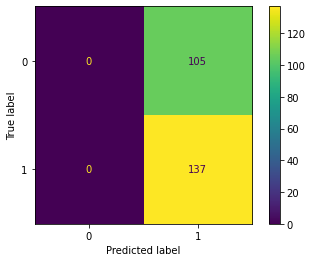

val Roc Auc: 0.7190852625635233
val Accuracy : 0.6260162601626016


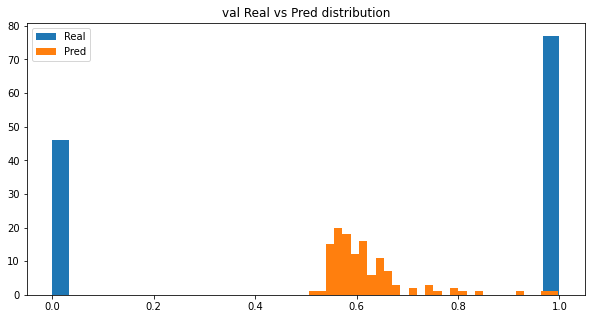

<Figure size 720x720 with 0 Axes>

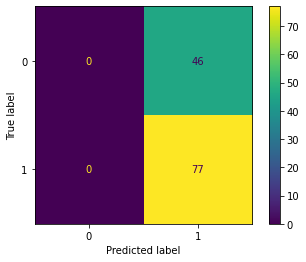

In [124]:
log_reg = best_lr_tf.fit(df_train['preprocessed_text'], df_train['label'])

log_reg_train_probs = log_reg.predict_proba(df_train['preprocessed_text']) #have
log_reg_test_probs = log_reg.predict_proba(df_test['preprocessed_text']) #have
log_reg_val_probs = log_reg.predict_proba(df_val['preprocessed_text']) #have

classification_report(
    train_probs = log_reg_train_probs[:,1],
    train_real = df_train["label"].astype(int).values,
    train_texts = df_train["preprocessed_text"].to_list(),

    test_probs=log_reg_test_probs[:,1],
    test_real=df_test["label"].astype(int).values,
    test_texts=df_test["preprocessed_text"].to_list(),

    val_probs=log_reg_val_probs[:,1],
    val_real=df_val["label"].astype(int).values,
    val_texts=df_val["preprocessed_text"].to_list(),
)

### Sentence Embeddings + Logistic Regression

train Roc Auc: 0.9212950805322129
train Accuracy : 0.8454545454545455


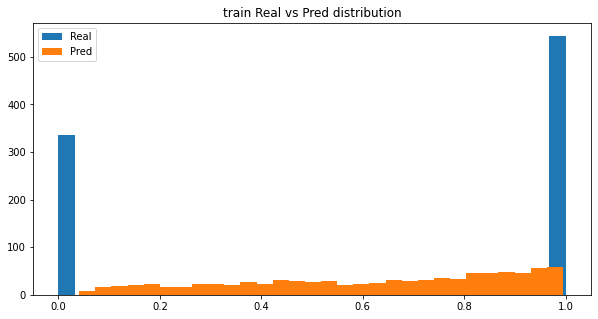

<Figure size 720x720 with 0 Axes>

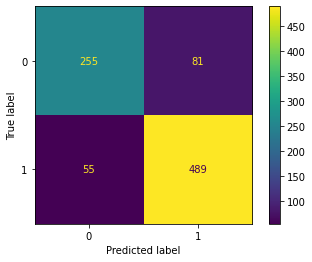

test Roc Auc: 0.7576067586297934
test Accuracy : 0.6975806451612904


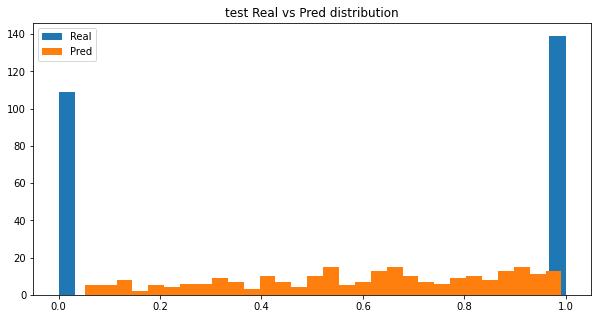

<Figure size 720x720 with 0 Axes>

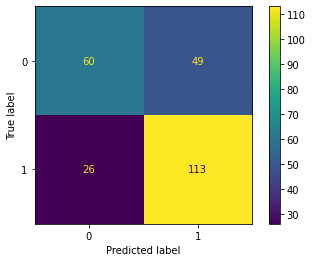

val Roc Auc: 0.747626582278481
val Accuracy : 0.7086614173228346


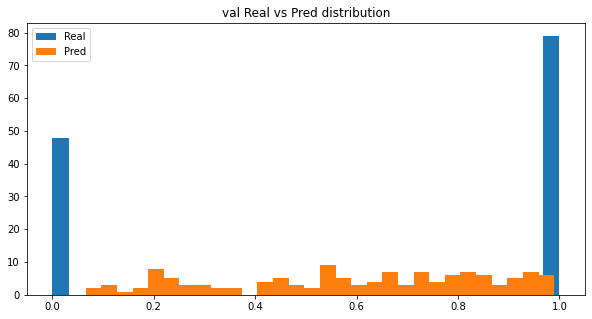

<Figure size 720x720 with 0 Axes>

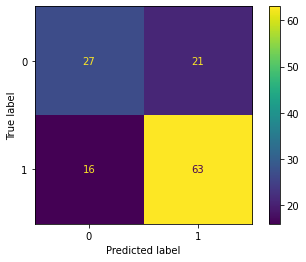

In [125]:
log_reg = best_emb.fit(train_embs, train['label'])

log_reg_train_probs = log_reg.predict_proba(train_embs) 
log_reg_test_probs = log_reg.predict_proba(test_embs) 
log_reg_val_probs = log_reg.predict_proba(val_embs) 

classification_report(
    train_probs = log_reg_train_probs[:,1],
    train_real = train["label"].astype(int).values,
    train_texts = train_embs,

    test_probs=log_reg_test_probs[:,1],
    test_real=test["label"].astype(int).values,
    test_texts=test_embs,

    val_probs=log_reg_val_probs[:,1],
    val_real=val["label"].astype(int).values,
    val_texts= val_embs,
)


###We can notice that while *roc auc scores* of all the models are quite ok, *accuracies* are really low. 
###We see a lot of false positive predictions in both Countvectorizer + Logistic Regression and Tfidfvectorizer + Logistic Regression combinations. However, Sentence Embeddings + Logistic Regression Pipeline performs a little bit better.

#Cross Validation for RNN

In [126]:
def comp_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]

    if verbose:
        for ra, tgt_col in zip(class_roc_aucs, ['label']):
            print(f"{tgt_col} Roc Auc: {ra}")
        print(f"Result Roc Auc: {np.mean(class_roc_aucs)}")
    return class_roc_aucs, np.mean(class_roc_aucs)

In [127]:
#RNN Class creation

class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        #TODO: What is bidirectional ? Try unidirectional
        #Answer: When it is bidirectional, the input flows in both directions. 
        #That's why RNN is capable of utilizing information from both sides. 

        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Linear(
            rnn_channels * 2 if bidirectional else rnn_channels, 
            out_channels, 
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [128]:
# I have chosen spaCy tokenization algorithm for russian.

tokenizer = get_tokenizer('spacy', language = 'ru_core_news_lg')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Vocabulary

vocab = build_vocab_from_iterator(
    yield_tokens(df_train["preprocessed_text"]), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [129]:
#Let's check vocabulary

vocab.lookup_tokens([3])

['россия']

In [130]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))

        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(np.array([self.targets[idx]])).float()
        )
    
    def __len__(self):
        return len(self.texts)

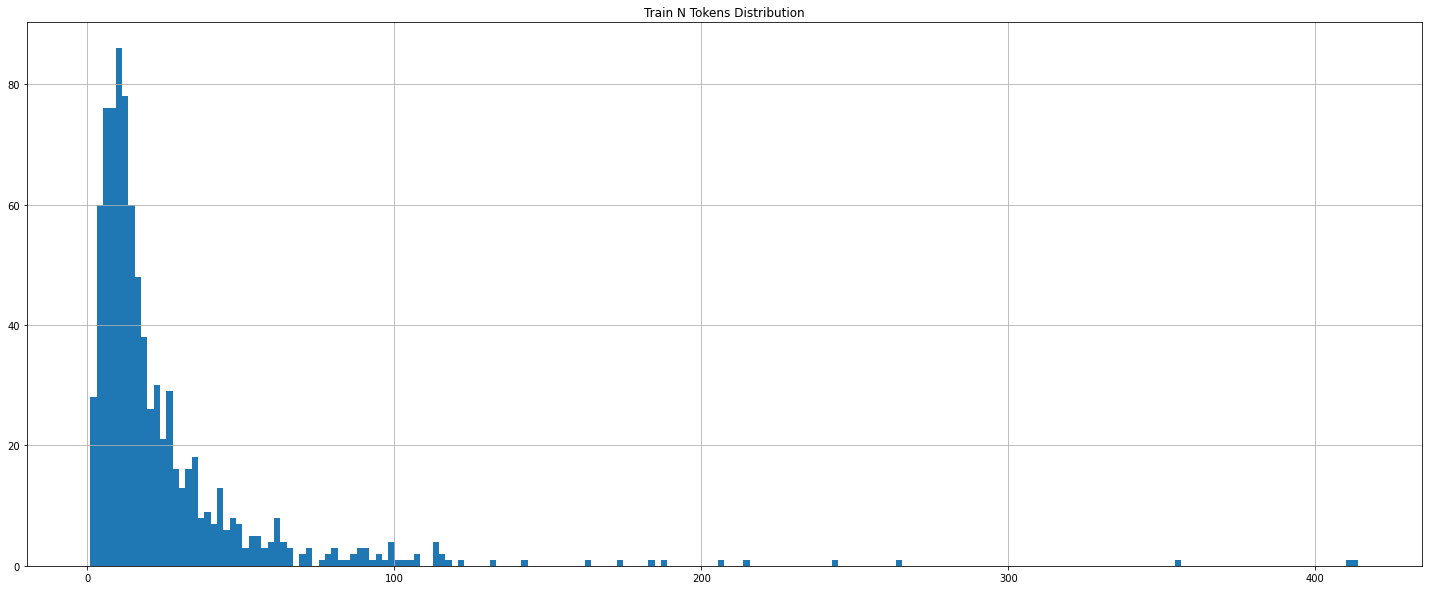

0.95 Quantile of N tokens: 82.39999999999986


In [131]:
# Let's figure out optimal length of a tensor
# Let it be 100.

train_n_tokens = df_train["preprocessed_text"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=200, figsize = (25,10))
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [132]:
train_torch_dataset = TextDataset(
    texts= df_train["preprocessed_text"].to_list(),
    targets=df_train['label'].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=100)

In [133]:
doc_idx = 32

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: сегодня подтвердиться наш инсайд зеленский отказаться эвакуироваться президент украина отклонить просьба сша эвакуация киев заявить нужный боеприпас транспорт 10420
Text Ids: tensor([  75, 1567,    9, 1433,   39,  732, 5939,   48,    1, 4534,  750,   86,
        2642,   10,   12,  116,  492, 1243, 2668,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Target: tensor([0.])
Text Ids length: 100


In [134]:
#Maybe max_length was chosen incorrectly because tensors contain a lot of zeros.

train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=4,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[   2, 2230,  363,   21,  118, 2321,  258,  285,  594,  183,    5,  235,
            8,  519,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 136,    3, 1145,   74,  666, 1445,  316,   79,  715, 2306,  203,  244,
          738,  101,  238,   74,   53,   74, 1509,  238,  267, 1527,  818,  127,
          203,  419,  875,  234,  101,  738,  203,  889, 1608,   42,  465,  263,
          550,   59, 1057, 1431,  184,  234, 1691,  853,    0

### PyTorch Train and Validation loop

In [135]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    # TODO: Read about train and eval modes on official Torch Docs. What do they change ?
    # Answer: They have effect only on certain modules. 

    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []

    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                loss.mean().backward()
                optimizer.step()

            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())

    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets


def print_losses(input):
  for cls_idx, tgt_col in enumerate(['label']):
      print(f"{tgt_col} BCE loss: {input[:,cls_idx].mean()}")
  print(f"Result BCE loss: {input.mean()}")

In [136]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    out_channels=1,
    average_type="mean"
).to("cpu")

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [137]:
train_torch_dataset = TextDataset(
    texts = df_train.iloc[all_folds[0][0]]["preprocessed_text"].to_list(),
    targets =df_train.iloc[all_folds[0][0]]["label"].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=100,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=4,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=df_train.iloc[all_folds[0][1]]["preprocessed_text"].to_list(),
    targets=df_train.iloc[all_folds[0][1]]['label'].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=100,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=4,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True
)

In [138]:
# TODO: Try to train longer 
# We have chosen 5 epochs instead of 3.

n_epochs = 5

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cpu",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    print("Train metrics")
    _, train_roc_auc = comp_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cpu",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    print("Valid metrics")
    _, valid_roc_auc = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    # 3. Update learning rate (if needed)
    scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

Starting Epoch 1
Train phase


100%|██████████| 173/173 [01:45<00:00,  1.64it/s]


Train metrics
label Roc Auc: 0.5596777065527065
Result Roc Auc: 0.5596777065527065
Train BCE losses
label BCE loss: 0.6913576126098633
Result BCE loss: 0.6913576126098633
Valid phase


100%|██████████| 44/44 [00:06<00:00,  7.28it/s]


Valid metrics
label Roc Auc: 0.679181369089626
Result Roc Auc: 0.679181369089626
Valid BCE losses
label BCE loss: 0.6508134603500366
Result BCE loss: 0.6508134603500366
Starting Epoch 2
Train phase


100%|██████████| 173/173 [01:41<00:00,  1.70it/s]


Train metrics
label Roc Auc: 0.8675836894586895
Result Roc Auc: 0.8675836894586895
Train BCE losses
label BCE loss: 0.4317857027053833
Result BCE loss: 0.4317857027053833
Valid phase


100%|██████████| 44/44 [00:05<00:00,  7.93it/s]


Valid metrics
label Roc Auc: 0.6866619618913198
Result Roc Auc: 0.6866619618913198
Valid BCE losses
label BCE loss: 0.6726925373077393
Result BCE loss: 0.6726925373077393
Starting Epoch 3
Train phase


100%|██████████| 173/173 [01:43<00:00,  1.68it/s]


Train metrics
label Roc Auc: 0.9857371794871794
Result Roc Auc: 0.9857371794871794
Train BCE losses
label BCE loss: 0.14259769022464752
Result BCE loss: 0.14259769022464752
Valid phase


100%|██████████| 44/44 [00:07<00:00,  5.88it/s]


Valid metrics
label Roc Auc: 0.6167960479887085
Result Roc Auc: 0.6167960479887085
Valid BCE losses
label BCE loss: 1.0762317180633545
Result BCE loss: 1.0762317180633545
Starting Epoch 4
Train phase


100%|██████████| 173/173 [01:42<00:00,  1.68it/s]


Train metrics
label Roc Auc: 0.9983618233618233
Result Roc Auc: 0.9983618233618233
Train BCE losses
label BCE loss: 0.03898470103740692
Result BCE loss: 0.03898470103740692
Valid phase


100%|██████████| 44/44 [00:05<00:00,  7.55it/s]


Valid metrics
label Roc Auc: 0.6427664079040225
Result Roc Auc: 0.6427664079040225
Valid BCE losses
label BCE loss: 1.2212741374969482
Result BCE loss: 1.2212741374969482
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 5
Train phase


100%|██████████| 173/173 [01:42<00:00,  1.68it/s]


Train metrics
label Roc Auc: 0.9999643874643875
Result Roc Auc: 0.9999643874643875
Train BCE losses
label BCE loss: 0.009973851032555103
Result BCE loss: 0.009973851032555103
Valid phase


100%|██████████| 44/44 [00:05<00:00,  8.34it/s]

Valid metrics
label Roc Auc: 0.6383909668313338
Result Roc Auc: 0.6383909668313338
Valid BCE losses
label BCE loss: 1.335800290107727
Result BCE loss: 1.335800290107727


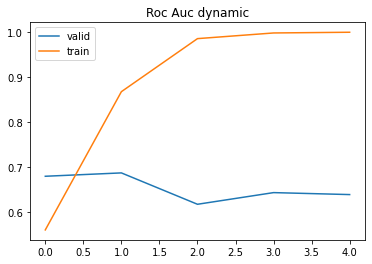

In [139]:
plt.title("Roc Auc dynamic")
plt.plot(valid_roc_aucs, label="valid")
plt.plot(train_roc_aucs, label="train")
plt.legend()
plt.show()

In [140]:
# Loading the best model
nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=df_test["preprocessed_text"].to_list(),
    targets=df_test['label'].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=100,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=4,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device="cpu",
    mode="eval"
)

100%|██████████| 61/61 [00:09<00:00,  6.65it/s]


In [141]:
print("Test metrics")
comp_metric(
    test_targets, 
    test_labels
);
print("Test BCE losses")
print_losses(test_losses)

Test metrics
label Roc Auc: 0.7120264164059784
Result Roc Auc: 0.7120264164059784
Test BCE losses
label BCE loss: 0.6481693983078003
Result BCE loss: 0.6481693983078003


###As we can see roc auc scores after RNN are also not very high.